## Deep RNN para Time Series + Dense output Layer

In [10]:
import warnings
warnings.filterwarnings('ignore')

import keras 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

#### Generacion de series temporales Artificiales

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size,1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[...,np.newaxis].astype(np.float32)

#### Creacion del Test y Train Set

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000,:n_steps], series[:7000,-1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:,:n_steps], series[9000:,-1]


X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

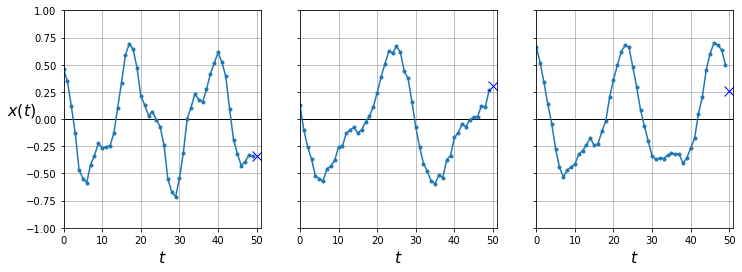

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### Entreamiento con Deep SimpleRNN + Dense en el output layer

Esta red construye una RNN con varas capas de celulas RNN. No hay necesidad de especificar el tamano del input shape ya que puede procesar cadenas de cualquier tamano. 

Algunas cosas:
- Esta red usa por defecto la funcion de activacion de Tangente Hiperbolica.
- el estado inicial de $h_{(t)} es 0$
- $h_{(t)}$ se comporta se retroalimenta la neurona con informacion anterior.
- por defecto keras solamente retorna el valor del ultimo step t. 
- para devolver sequencias se debe definir return_sequences = True

**Nota**

- Removemos return_sequences = True de la capa antes de Dense
- cambiamos la capa final por Dense
- la red converge mas rapido*

In [8]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1),
])

model.compile(loss='mse', optimizer="adam", metrics=['mae', 'mse'])
history = model.fit(X_train, y_train, epochs=20, verbose=1,  validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 4s 635us/step - loss: 0.0234 - mae: 0.1002 - mse: 0.0234 - val_loss: 0.0042 - val_mae: 0.0520 - val_mse: 0.0042
Epoch 2/20
7000/7000 [==============================] - 4s 600us/step - loss: 0.0041 - mae: 0.0515 - mse: 0.0041 - val_loss: 0.0034 - val_mae: 0.0474 - val_mse: 0.0034
Epoch 3/20
7000/7000 [==============================] - 4s 599us/step - loss: 0.0037 - mae: 0.0485 - mse: 0.0037 - val_loss: 0.0031 - val_mae: 0.0452 - val_mse: 0.0031
Epoch 4/20
7000/7000 [==============================] - 4s 597us/step - loss: 0.0034 - mae: 0.0468 - mse: 0.0034 - val_loss: 0.0035 - val_mae: 0.0479 - val_mse: 0.0035
Epoch 5/20
7000/7000 [==============================] - 4s 598us/step - loss: 0.0033 - mae: 0.0458 - mse: 0.0033 - val_loss: 0.0031 - val_mae: 0.0449 - val_mse: 0.0031
Epoch 6/20
7000/7000 [==============================] - 4s 598us/step - loss: 0.0033 - mae: 0.0457 - mse: 0.0033

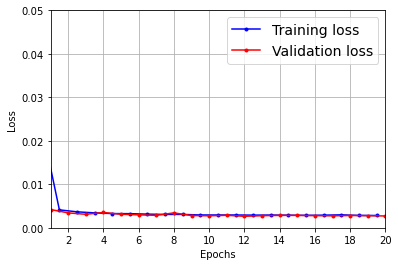

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

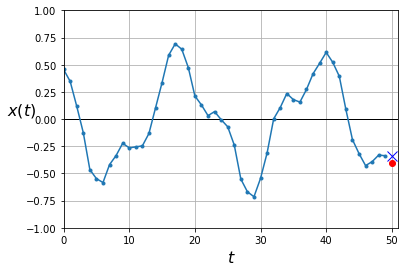

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()